## Web Voyager

[WebVoyager](https://arxiv.org/abs/2401.13919) by He, et. al., is a vision-enabled web-browsing agent capable of controlling the mouse and keyboard.

It works by viewing annotated browser screenshots for each turn, then choosing the next step to take. The agent architecture is a basic reasoning and action (ReAct) loop.
The unique aspects of this agent are:
- It's using a supervisor node to control the chain of command between different parts of the operation.
- It's using of [Set-of-Marks](https://som-gpt4v.github.io/)-like image annotations to serve as UI affordances for the agent.
- It's using playwright application in the browser and is using tools to control both the mouse and keyboard to perform actions.

The overall design looks like the following:

<!-- ![Voyager Image](./img/web-voyager.excalidraw.png) -->
<img src="./img/web-voyager.excalidraw.png" width="50%">


## Configure environment

We will first set up LangSmith tracing. Though optional, this lets us inspect and debug agent's trajectory for a given input.

You can sign up at [smith.langchain.com](https://smith.langchain.com/) to get an API key.

In [1]:
!pip install -U --quiet langgraph langsmith langchain_openai langchain langchainhub


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Optional: add tracing to visualize the agent trajectories
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Web-Voyager"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["OPENAI_API_KEY"] = "sk-proj-QrLB1NSENFsnjGJrrfehT3BlbkFJB0YTmsNVoBOQ22xbWAC0"

#### Install Agent requirements

The only additional requirement we have is the [playwright](https://playwright.dev/) browser.

In [3]:
!pip install --upgrade --quiet  playwright
!playwright install


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import nest_asyncio

# This is just required for running async playwright in a Jupyter notebook
nest_asyncio.apply()

## Define Graph State

The state provides the inputs to each node in the graph.

In our case, the agent will track the webpage object (within the browser), annotated images + bounding boxes, the user's initial request, and the messages containing the agent scratchpad, system prompt, and other information.


In [5]:
from typing import List, Optional, TypedDict

from langchain_core.messages import BaseMessage, SystemMessage
from playwright.async_api import Page


class BBox(TypedDict):
    x: float
    y: float
    text: str
    type: str
    ariaLabel: str


class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]


# This represents the state of the agent
# as it proceeds through execution
class AgentState(TypedDict):
    page: Page  # The Playwright web page lets us interact with the web environment
    input: str  # User request
    img: str  # b64 encoded screenshot
    bboxes: List[BBox]  # The bounding boxes from the browser annotation function
    prediction: Prediction  # The Agent's output
    # A system message (or messages) containing the intermediate steps
    scratchpad: List[BaseMessage]
    observation: str  # The most recent response from a tool

## Define tools

The agent has 6 simple tools:

1. Click (at labeled box)
2. Type
3. Scroll
4. Wait
5. Go back
6. Go to search engine (Google)


We define them below here as functions:

In [6]:
import asyncio
import platform


async def click(state: AgentState):
    # - Click [Numerical_Label]
    page = state["page"]
    click_args = state["prediction"]["args"]
    if click_args is None or len(click_args) != 1:
        return f"Failed to click bounding box labeled as number {click_args}"
    bbox_id = click_args[0]
    bbox_id = int(bbox_id)
    try:
        bbox = state["bboxes"][bbox_id]
    except Exception:
        return f"Error: no bbox for : {bbox_id}"
    x, y = bbox["x"], bbox["y"]
    await page.mouse.click(x, y)
    return f"Clicked {bbox_id}"


async def type_text(state: AgentState):
    page = state["page"]
    type_args = state["prediction"]["args"]
    if type_args is None or len(type_args) != 2:
        return (
            f"Failed to type in element from bounding box labeled as number {type_args}"
        )
    bbox_id = type_args[0]
    bbox_id = int(bbox_id)
    bbox = state["bboxes"][bbox_id]
    x, y = bbox["x"], bbox["y"]
    text_content = type_args[1]
    await page.mouse.click(x, y)
    # Check if MacOS
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(text_content)
    await page.keyboard.press("Enter")
    return f"Typed {text_content} and submitted"


async def scroll(state: AgentState):
    page = state["page"]
    scroll_args = state["prediction"]["args"]
    if scroll_args is None or len(scroll_args) != 2:
        return "Failed to scroll due to incorrect arguments."

    target, direction = scroll_args

    if target.upper() == "WINDOW":
        # Not sure the best value for this:
        scroll_amount = 500
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
    else:
        # Scrolling within a specific element
        scroll_amount = 200
        target_id = int(target)
        bbox = state["bboxes"][target_id]
        x, y = bbox["x"], bbox["y"]
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_direction)

    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"


async def wait(state: AgentState):
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return f"Waited for {sleep_time}s."


async def go_back(state: AgentState):
    page = state["page"]
    await page.go_back()
    return f"Navigated back a page to {page.url}."


async def to_google(state: AgentState):
    page = state["page"]
    await page.goto("https://www.google.com/")
    return "Navigated to google.com."

## Define Agent

The agent is driven by a multi-modal model and decides the action to take for each step. It is composed of a few runnable objects:

1. A `mark_page` function to annotate the current page with bounding boxes
2. A prompt to hold the user question, annotated image, and agent scratchpad
3. GPT-4o to decide the next steps
4. Parsing logic to extract the action for the tools defined


Let's first define the annotation step:
#### Browser Annotations

This function annotates all buttons, inputs, text areas, etc. with numbered bounding boxes. GPT-4V then just has to refer to a bounding box
when taking actions, reducing the complexity of the overall task.

In [7]:
import base64

from langchain_core.runnables import chain as chain_decorator

'''Some javascript we will run on each step
select the# elements to annotate, add bounding boxes
and then take a screenshot'''

with open(r"C:\Users\vishn\Downloads\mark_page.js") as f:
    mark_page_script = f.read()


@chain_decorator
async def mark_page(page):
    await page.evaluate(mark_page_script)
    for _ in range(10):
        try:
            bboxes = await page.evaluate("markPage()")
            break
        except Exception:
            # May be loading...
            asyncio.sleep(3)
    screenshot = await page.screenshot()
    # Ensure the bboxes don't follow us around
    await page.evaluate("unmarkPage()")
    return {
        "img": base64.b64encode(screenshot).decode(),
        "bboxes": bboxes,
    }

#### Agent definition

Now we'll compose this function with the prompt, llm and output parser to complete our agent.

In [40]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

# Uses the above defined mark_page function to modify the state
async def annotate(state):
    marked_page = await mark_page.with_retry().ainvoke(state["page"])
    return {**state, **marked_page}

# Creates descriptions of the bounding boxes such that the LLM understands better
def format_descriptions(state):
    labels = []
    for i, bbox in enumerate(state["bboxes"]):
        text = bbox.get("ariaLabel") or ""
        if not text.strip():
            text = bbox["text"]
        el_type = bbox.get("type")
        labels.append(f'{i} (<{el_type}/>): "{text}"')
    bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)
    return {**state, "bbox_descriptions": bbox_descriptions}

# Used to parse the LLM output to extract the next action required in the flow
def parse(text: str) -> dict:
    action_prefix = "Action: "
    if not text.strip().split("\n")[-1].startswith(action_prefix):
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    action_block = text.strip().split("\n")[-1]

    action_str = action_block[len(action_prefix) :]
    split_output = action_str.split(" ", 1)
    if len(split_output) == 1:
        action, action_input = split_output[0], None
    else:
        action, action_input = split_output
    action = action.strip()
    if action_input is not None:
        action_input = [
            inp.strip().strip("[]") for inp in action_input.strip().split(";")
        ]
    return {"action": action, "args": action_input}

# Using a pre-defined template from the reference guide
prompt = hub.pull("wfh/web-voyager:8b927604")

ChatPromptTemplate(input_variables=['bbox_descriptions', 'img', 'input'], input_types={'scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, partial_variables={'scratchpad': []}, metadata={'lc_hub_owner': 'wfh', 'lc_hub_repo': 'web-voyager', 'lc_hub_commit_hash': '8b9276048be8aec78203e8c45c9e15bc3a46e4b3275b05ef727563a2887ebaab'}, messages=[SystemMessagePromptTemplate(prompt=[PromptTemplate(input_variables=[], template="Imagine you are a robot browsing the web, just like humans. Now you need to complete a task. In each iteration, you will receive an Observation that includes a screenshot of a webpage and some texts. This screenshot will\nfeature Numerical Labels placed in the TOP LEFT corner of each Web Element. Carefully analyze the visual

In [9]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", max_tokens=4096)
agent = annotate | RunnablePassthrough.assign(
    prediction=format_descriptions | prompt | llm | StrOutputParser() | parse
)

## Define graph

We've created most of the important logic. We have one more function to define that will help us update the graph state after a tool is called.

In [10]:
import re


def update_scratchpad(state: AgentState):
    """After a tool is invoked, we want to update
    the scratchpad so the agent is aware of its previous steps"""
    old = state.get("scratchpad")
    if old:
        txt = old[0].content
        last_line = txt.rsplit("\n", 1)[-1]
        step = int(re.match(r"\d+", last_line).group()) + 1
    else:
        txt = "Previous action observations:\n"
        step = 1
    txt += f"\n{step}. {state['observation']}"

    return {**state, "scratchpad": [SystemMessage(content=txt)]}

Now we can compose everything into a graph:

In [12]:
from langchain_core.runnables import RunnableLambda

from langgraph.graph import END, StateGraph


#Since all the 3 agents used are for web-navigation, the same function can be used to create graphs for each agent

def sub_graph_builder(AgentState):
    graph_builder = StateGraph(AgentState)


    graph_builder.add_node("agent", agent)
    graph_builder.set_entry_point("agent")

    graph_builder.add_node("update_scratchpad", update_scratchpad)
    graph_builder.add_edge("update_scratchpad", "agent")

    tools = {
        "Click": click,
        "Type": type_text,
        "Scroll": scroll,
        "Wait": wait,
        "GoBack": go_back,
        "Google": to_google,
    }


    for node_name, tool in tools.items():
        graph_builder.add_node(
            node_name,
            # The lambda ensures the function's string output is mapped to the "observation"
            # key in the AgentState
            RunnableLambda(tool) | (lambda observation: {"observation": observation}),
        )
        # Always return to the agent (by means of the update-scratchpad node)
        graph_builder.add_edge(node_name, "update_scratchpad")


    def select_tool(state: AgentState):
        # Any time the agent completes, this function
        # is called to route the output to a tool or
        # to the end user.
        action = state["prediction"]["action"]
        if action == "ANSWER":
            return END
        if action == "retry":
            return "agent"
        return action


    graph_builder.add_conditional_edges("agent", select_tool)

    graph = graph_builder.compile()
    
    return graph 

# Creating the subgraphs
Property_details_retreival_graph = sub_graph_builder(AgentState)
CCnR_document_details_retreival_graph = sub_graph_builder(AgentState)
CCnR_downloader_graph = sub_graph_builder(AgentState)    

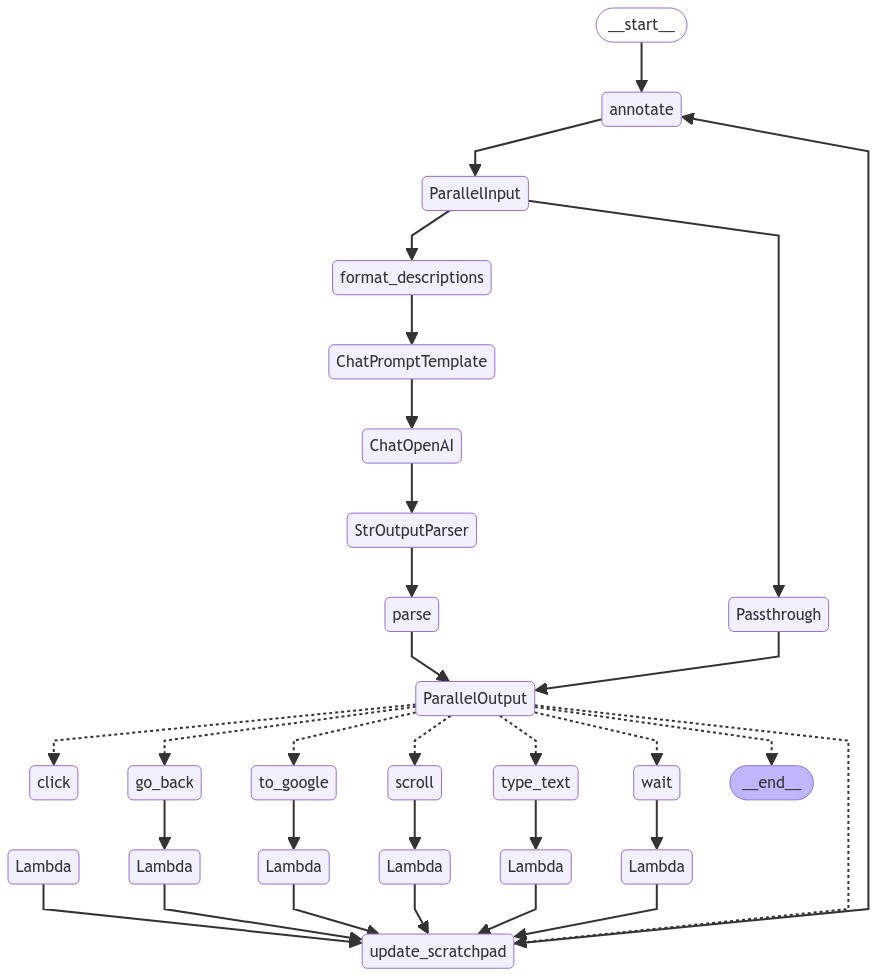

In [35]:
from IPython.display import Image, display

display(Image(CCnR_downloader_graph.get_graph(xray=True).draw_mermaid_png()))

In [28]:
from IPython import display
from playwright.async_api import async_playwright


async def call_agent(agent_input: str, graph, max_steps: int = 150):
    browser = await async_playwright().start()
    # We will set headless=False so we can watch the agent navigate the web.
    browser = await browser.chromium.launch(headless=True, args=None)
    page = await browser.new_page()
    _ = await page.goto("https://www.google.com")
    event_stream = graph.astream(
        {
            "page": page,
            "input": agent_input,
            "scratchpad": [],
        },
        {
            "recursion_limit": max_steps,
        },
    )
    final_answer = None
    steps = []
    async for event in event_stream:
        # We'll display an event stream here
        if "agent" not in event:
            continue
        pred = event["agent"].get("prediction") or {}
        action = pred.get("action")
        action_input = pred.get("args")
        display.clear_output(wait=False)
        steps.append(f"{len(steps) + 1}. {action}: {action_input}")
        print("\n".join(steps))
        display.display(display.Image(base64.b64decode(event["agent"]["img"])))
        if "ANSWER" in action:
            final_answer = action_input[0]
            await browser.close()
            break
    return final_answer

## Creating Super-graph 

In this design, we are enforcing a top-down planning policy. We've created three graphs already for the execution of the various parts of the complex task, but we have to decide how to route work between the three.

We'll create a 4th graph to orchestrate the previous three, and add some connectors to define how this top-level state is shared between the different graphs.

In [14]:
from typing import List, Optional

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph, START

def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

In [15]:
from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. These are the general steps you will need to follow when the human asks you to download CC&R documents (these are just recommendations and not hard rules):\n"
    "1) Search for the property name, find out any specific details such as the parcel number from websites.\n"
    "2) Go to the respective county's recorder of deeds website and use the info gained in the 1st step or the address to search for which may contain reference to the hoa CC&Rs such as document number/ book and page number.\n"
    "3) Parse the document to search for the CC&R's document number or book and page number.\n"
    "4) Search for the CC&R using document number or book and page number retreived in the 3rd step on the same county's website\n"
    "Please note:\n"
    "1) You will initially be provided with an address or a county name, and you'll need to help the human navigate the web till they reach the download button to download the Covenants, Conditions, and Restrictions document of the most relevant HOA, then ask to click the download button\n"
    "2) If you conclude that the HOA does not exist, please ask the human to skip that particular property in the ANSWER; [content] format.\n"
    "Given the following user request of an address to retreive the CC&R documents of,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Property_details_retreiver", "CCnR_document_details_retreiver", "CCnR_downloader"],
)

In [31]:
from typing import Annotated
import functools
import operator

# Top-level graph state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str

# Creating prompts specific to the different agents being called by the supervisor

def create_input_for_CCRD(state: State) -> str:
    sp_prompt = ("You're part of a team employed to retreive CCnR documents of a property. Your task here is to download the "
                 "Covenants, Conditions, and Restrictions (CCNR) document from the county's recorder of deeds website.\n"
                 "Given the details required such as a document number/book and page number, locate the download button for the "
                 "CCNR document and click on it such that it downloades\n"
                 "You should visit the county's recorder of deeds website and look for the CCNR document. "
                 "You can use the given details to search in the recordings section of the website. Here's what we know so far:\n"
                )
    agent_input = sp_prompt + state["messages"][-1].content
    return agent_input, CCnR_downloader_graph

def create_input_for_CCRDR(state: State) -> str:
    sp_prompt = ("You're part of a team employed to retreive CCnR documents of a property. Your task here is to retreive "
                 "STRICTLY either the document number or the book and page number that can be used to search for the  "
                 "Covenants, Conditions, and Restrictions (CCNRs) for the input property\n"
                 "Given the relevant property details and county name, return STRICTLY either the document number or "
                 "the book and page number for the address and county provided\n"
                 "You should visit the county's recorder of deeds website and look for documents that may contain the "
                 "document number/book and page number of the CCNR document. You can use what we have so far to search in the "
                 "recordings section of the website. Here's what we know so far:\n"
                )
    agent_input = sp_prompt + state["messages"][-1].content
    return agent_input, CCnR_document_details_retreival_graph

def create_input_for_PDR(state: State) -> str:
    sp_prompt = ("You're part of a team employed to retreive CCnR documents of a property. Your task here is to retreive "
                 "relevant property details (such as parcel number or complete address) that would be useful to be able to search "
                 "the county recorder of deeds website for deed/declaration documents for that particular property\n"
                 "Given the address of the property, return the relevant property details and county name of the property. Here's "
                 "what we know so far:\n"
                 "You may browse the web searching with the property address and visit websites that may contain the information "
                 "you are looking for. Here's what we know so far:\n"
                )
    agent_input = sp_prompt + state["messages"][-1].content
    return agent_input, Property_details_retreival_graph

def join_graph(response: dict):
    return {"messages": [response["observation"]]}

# Define the graph.
super_graph = StateGraph(State)
# First add the nodes, which will do the work
super_graph.add_node("Property_details_retreiver", create_input_for_PDR |  
                     RunnableLambda(lambda x : call_agent(x[0], x[1])) | join_graph)
super_graph.add_node("CCnR_document_details_retreiver", create_input_for_CCRDR | 
                     RunnableLambda(lambda x : call_agent(x[0], x[1])) | join_graph)
super_graph.add_node("CCnR_downloader", create_input_for_PDR | 
                     RunnableLambda(lambda x : call_agent(x[0], x[1])) | join_graph)
super_graph.add_node("supervisor", supervisor_node)


# Define the graph connections, which controls how the logic
# propagates through the program
super_graph.add_edge("Property_details_retreiver", "supervisor")
super_graph.add_edge("CCnR_document_details_retreiver", "supervisor")
super_graph.add_edge("CCnR_downloader", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "Property_details_retreiver" : "Property_details_retreiver",
        "CCnR_document_details_retreiver" : "CCnR_document_details_retreiver",
        "CCnR_downloader" : "CCnR_downloader",
        "FINISH": END,
    },
)
super_graph.add_edge(START, "supervisor")
super_graph = super_graph.compile()

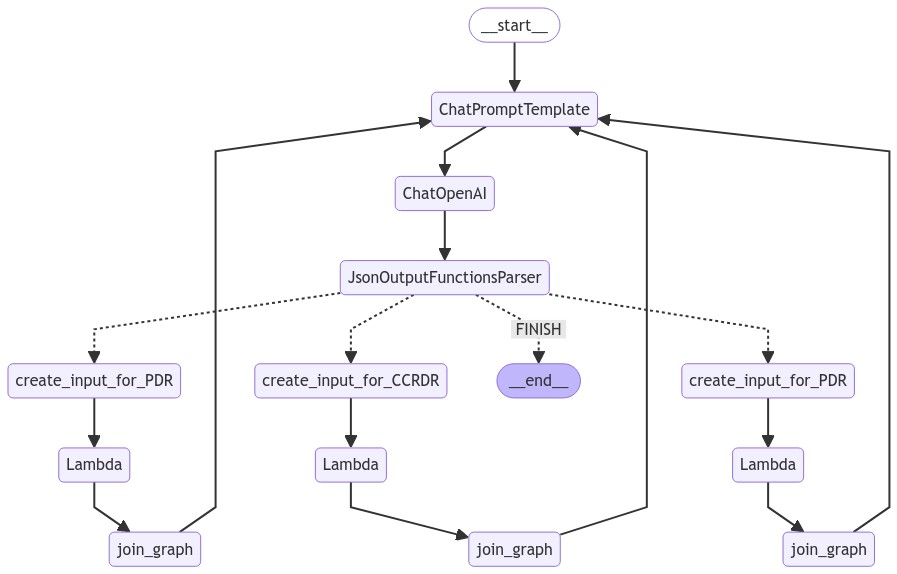

In [34]:
from IPython.display import Image, display

display(Image(super_graph.get_graph(xray=True).draw_mermaid_png()))

## Run agent

Now that we've created the whole agent executor, we can run it on a few addresses! 

Below is a helper function to help print out the steps to the notebook.

In [ ]:
def run_super_graph(human)
    for s in super_graph.stream(
        {
            "messages": [
                HumanMessage(
                    content=human
                )
            ],
        },
        {"recursion_limit": 150},
    ):
        if "__end__" not in s:
            print(s)
            print("---")

In [ ]:
human = "Please download the relevant Covenants, Conditions, and Restrictions document for the address: 1130 Whitehawk Trl, Lawrenceville, GA 30043"

res = await run_super_graph(human)
print(f"Final response: {res}")

In [ ]:
res = await call_agent(
    "Please explain the today's XKCD comic for me. Why is it funny?", page
)
print(f"Final response: {res}")

In [ ]:
res = await call_agent("What are the latest blog posts from langchain?", page)
print(f"Final response: {res}")

In [ ]:
res = await call_agent(
    "Could you check google maps to see when i should leave to get to SFO by 7 o'clock? starting from SF downtown.",
    page,
)
print(f"Final response: {res}")